In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = "/home/xuwentao/IPT-2026/test-videos/cut-3.mp4"  # 改成你的

cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), "视频打不开，检查路径"

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
ok, frame0 = cap.read()
cap.release()
assert ok, "读第一帧失败"

# 不要在 WSL + VS Code 的 Notebook 里用 cv2.selectROI（容易卡住）。
# ROI 选择放到下一个单元格里做。


SyntaxError: no binding for nonlocal 'roi' found (1474906964.py, line 25)

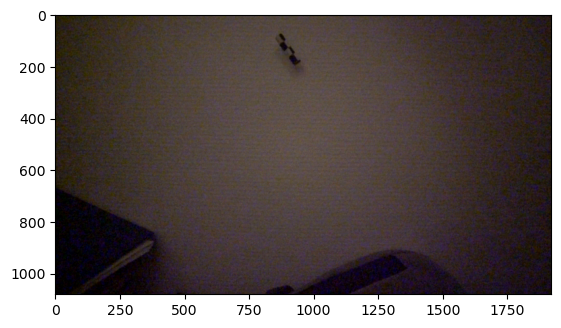

In [8]:
# 尝试使用交互式后端；如果不可用就回退到手动输入 ROI
try:
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "widget")
    _backend = "widget"
except Exception:
    try:
        if ip is not None:
            ip.run_line_magic("matplotlib", "inline")
    except Exception:
        pass
    _backend = "inline"

import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector

fig, ax = plt.subplots()
ax.imshow(frame0[..., ::-1])  # BGR->RGB

roi = None

if _backend == "widget":
    def onselect(eclick, erelease):
        nonlocal roi
        x1, y1 = int(eclick.xdata), int(eclick.ydata)
        x2, y2 = int(erelease.xdata), int(erelease.ydata)
        roi = (min(x1, x2), min(y1, y2), abs(x2 - x1), abs(y2 - y1))
        print("roi:", roi)
        return roi

    rs = RectangleSelector(ax, onselect, drawtype="box", useblit=True)
    plt.show()
    # 选完后看 roi
else:
    plt.show()
    s = input("输入 ROI x,y,w,h (用逗号分隔): ").strip()
    x, y, w, h = [int(v) for v in s.split(",")]
    roi = (x, y, w, h)
    print("roi:", roi)

roi


In [ ]:
x, y, w, h = map(int, roi)
gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
roi0 = gray0[y:y+h, x:x+w]

# 找角点（可以调 maxCorners / qualityLevel）
p0 = cv2.goodFeaturesToTrack(
    roi0,
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=5,
    blockSize=7
)

assert p0 is not None and len(p0) >= 10, "ROI里角点太少，换个更包含格子/边缘的ROI"

# 坐标从 ROI 局部换到全图坐标
p0[:,0,0] += x
p0[:,0,1] += y

len(p0)


ValueError: invalid literal for int() with base 10: 'rect'